In [59]:
import sys, os
import pandas as pd
import numpy as np

# Simple Python 3 compatiblity adjustment.
if sys.version_info[0] == 2:
    range = xrange

import os
import timeit

MODE = 'dll'  # 'dll' or 'com'

if MODE == 'com':
    import phreeqpy.iphreeqc.phreeqc_com as phreeqc_mod
elif MODE == 'dll':
    import phreeqpy.iphreeqc.phreeqc_dll as phreeqc_mod
else:
    raise Exception('Mode "%s" is not defined use "com" or "dll".' % MODE)

In [60]:
def uphill():
    """
    Specify initial conditions data blocks.

    Uniform initial conditions are assumed.
    """
    initial_conditions = """
    SOLUTION 0
     pH 6 charge; N(5) 1e-3; Na 0.1; Cl 0.1
    END
    PRINT; -reset false; -status false
    SOLUTION 1-20
     pH 4 charge; N(5) 0.1; Na 0.1; Cl 0.1
    TRANSPORT
     -cells 10
     -lengths 1e-3
     -boundary_conditions flux
     -shifts 1
     -flow_direction diffusion_only
     -time 3600
     -multi_d true 1e-9 1 0.0 1.0 # Default D_w m2/s, porosity, porosity limit, exponent
     -punch_cells 0-10
    SELECTED_OUTPUT
        -file            data/uphill.csv
        -reset           false
        -step
        -totals          Na H+ N(5) Cl
        -distance        true
        """
    return initial_conditions

def get_selected_output(phreeqc):
    """Return calculation result as dict.

    Header entries are the keys and the columns
    are the values as lists of numbers.
    """
    output = phreeqc.get_selected_output_array()
    header = output[0]
    conc = {}
    for head in header:
        conc[head] = []
    for row in output[1:]:
        for col, head in enumerate(header):
            conc[head].append(row[col])
    return conc

In [61]:
    phreeqc = phreeqc_mod.IPhreeqc()
    phreeqc.load_database(r"/usr/local/share/doc/iphreeqc/database/phreeqc.dat")
    initial_conditions = uphill()
    phreeqc.set_selected_output_file_on()
    phreeqc.run_string(initial_conditions)
#     selected_output = get_selected_ouput(components)
#     phreeqc.run_string(selected_output)

In [62]:
## reading results
# os.getcwd()
results = pd.read_csv('data/uphill.csv', sep = '\t', skipinitialspace=True)
results = results.drop([0,1])
results = results.iloc[:, :-1]
# results = results[results['step'] == 1]
# results = results.str.strip()
results

,dist_x,step,Na,H+,N(5),Cl
2,0.0005,0,0.0001,0.0,9.986900e-05,0.0001
3,0.0015,0,0.0001,0.0,9.986900e-05,0.0001
4,0.0025,0,0.0001,0.0,9.986900e-05,0.0001
5,0.0035,0,0.0001,0.0,9.986900e-05,0.0001
6,0.0045,0,0.0001,0.0,9.986900e-05,0.0001
7,0.0055,0,0.0001,0.0,9.986900e-05,0.0001
8,0.0065,0,0.0001,0.0,9.986900e-05,0.0001
9,0.0075,0,0.0001,0.0,9.986900e-05,0.0001
10,0.0085,0,0.0001,0.0,9.986900e-05,0.0001
11,0.0095,0,0.0001,0.0,9.986900e-05,0.0001


In [57]:
results.melted = pd.melt(results, id_vars = ['dist', 'step'], value_vars=['Na+', 'H+', 'NO3-', 'Cl-'])
results.melted

,dist,step,variable,value
0,0.5,0,Na+,0.100000
1,1.5,0,Na+,0.100000
2,2.5,0,Na+,0.100000
3,3.5,0,Na+,0.100000
4,4.5,0,Na+,0.100000
...,...,...,...,...
79,5.5,1,Cl-,0.086938
80,6.5,1,Cl-,0.088305
81,7.5,1,Cl-,0.089681
82,8.5,1,Cl-,0.090773


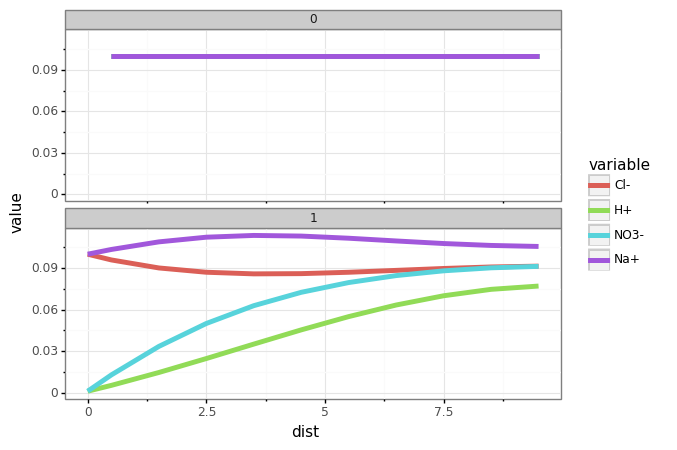

<ggplot: (8760809652405)>

In [58]:
from plotnine import *

# plotnine.options.figure_size = (6.4*2, 4.8*2)

(ggplot(results.melted, aes('dist', 'value', color='variable'))
 + geom_line(size = 2)
 + facet_wrap('~step', ncol = 1)
 + theme_bw()
 )